# Setup for this notebook

1) Poliastro:

```bash
git clone git://github.com/s-m-e/poliastro.git
cd poliastro
git checkout 879f7ab62d05361aff88575bd060d8ff9f880a14
pip install -e .
```

2) Extra packages

```bash
pip install joblib orbitalpy psutil
```

3) Data: 

```bash
wget https://minorplanetcenter.net/Extended_Files/nea_extended.json.gz
gzip -d nea_extended.json.gz
```

# Loading test data: Near Earth Asteroid (NEA) orbits from the MPC

In [1]:
FN = 'nea_extended.json'

import json

from astropy import units as u
from joblib import Parallel, delayed
import numpy as np
from orbital.utilities import true_anomaly_from_mean
import psutil

from poliastro.bodies import Sun

In [2]:
K = Sun.k.to_value(u.km**3 / u.s**2)

def _orbit_from_mpc(body):
    nu = true_anomaly_from_mean(
        e = body['e'],
        M = float((body['M'] * u.deg).to(u.rad).value)
    ) * u.rad
    if not -np.pi * u.rad <= nu < np.pi * u.rad:
        nu = ((nu + np.pi * u.rad) % (2 * np.pi * u.rad) - np.pi * u.rad).to(nu.unit)
    return (
        ((body['a'] * u.AU).to_value(u.km) * (1 - body['e']**2)),  # a
        body['e'],  # ecc
        (body['i'] * u.deg).to_value(u.rad),  # inc
        (body['Node'] * u.deg).to_value(u.rad),  # raan
        (body['Peri'] * u.deg).to_value(u.rad),  # argp
        nu.to_value(u.rad),  # nu
    )

def _read_mpc(fn):
    with open(fn, 'r', encoding = 'utf-8') as f:
        raw = json.load(f)
    return Parallel(n_jobs = psutil.cpu_count(logical = True))(delayed(_orbit_from_mpc)(body) for body in raw)

mpc_orbits = np.array(_read_mpc(FN), dtype = 'f8')

# Import of poliastro's new `jit` infrastructure

In [3]:
from math import cos, sin, sqrt
import os

import numpy as np

# POLIASTRO_TARGET can be set to `cpu`, `parallel` or `cuda`. Default: `cpu`
os.environ['POLIASTRO_TARGET'] = 'parallel'  

# POLIASTRO_INLINE can be set to `always` or `never`. Default: `never`
os.environ['POLIASTRO_INLINE'] = 'no'

from poliastro.core.jit import gjit, hjit, vjit, TARGET, INLINE

print(TARGET, INLINE)  # verfication

parallel False


# Relevant portions of core

In [4]:
from poliastro.core.propagation.farnocchia import farnocchia_coe_, farnocchia_rv_
from poliastro.core.elements import coe2rv_

In [5]:
@gjit(
    'void(f,f[:],f[:])',
    '(),(n)->(n)',  # should read (),(6)->(6)
)
def coe2rv(k, coe, rv):
    """
    Converts from classical orbital elements to state vectors ON ARRAYS
    coe[0...5] : p, ecc, inc, raan, argp, nu
    rv[0...5] : rx, ry, rz, vx, vy, vz
    """
    (rv[0], rv[1], rv[2]), (rv[3], rv[4], rv[5]) = coe2rv_(k, coe[0], coe[1], coe[2], coe[3], coe[4], coe[5])

@vjit('f(f,f,f,f,f,f,f,f)')
def farnocchia_coe(k, p, ecc, inc, raan, argp, nu, tof):
    return farnocchia_coe_(k, p, ecc, inc, raan, argp, nu, tof)

# Testing

We are dealing with around 20k NEAs.

In [6]:
DAY = 3600 * 24  # seconds
tofs = np.arange(0, 20 * DAY, DAY, dtype = 'f8')
tofs

array([      0.,   86400.,  172800.,  259200.,  345600.,  432000.,
        518400.,  604800.,  691200.,  777600.,  864000.,  950400.,
       1036800., 1123200., 1209600., 1296000., 1382400., 1468800.,
       1555200., 1641600.])

In [7]:
mpc_orbits.shape

(20250, 6)

In [8]:
tofs.shape

(20,)

In [9]:
nus = farnocchia_coe(
    K,
    mpc_orbits[:, None, 0],  # p
    mpc_orbits[:, None, 1],  # ecc
    mpc_orbits[:, None, 2],  # inc
    mpc_orbits[:, None, 3],  # raan
    mpc_orbits[:, None, 4],  # argp
    mpc_orbits[:, None, 5],  # nu
    tofs[None, :],
)

In [10]:
nus.shape

(20250, 20)

In [11]:
mpc_orbits_prop = np.tile(mpc_orbits[:, None, :], (1, nus.shape[1], 1))  # add dim for propagation
mpc_orbits_prop.shape

(20250, 20, 6)

In [12]:
mpc_orbits_prop[:, :, -1] = nus[:, :]  # write nus into orbit_prop array

In [13]:
mpc_orbits_prop_rv = coe2rv(K, mpc_orbits_prop)
mpc_orbits_prop_rv.shape

(20250, 20, 6)

# Interactive

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

AU = 149_597_870  # km
R = 3.0

plt.ion()

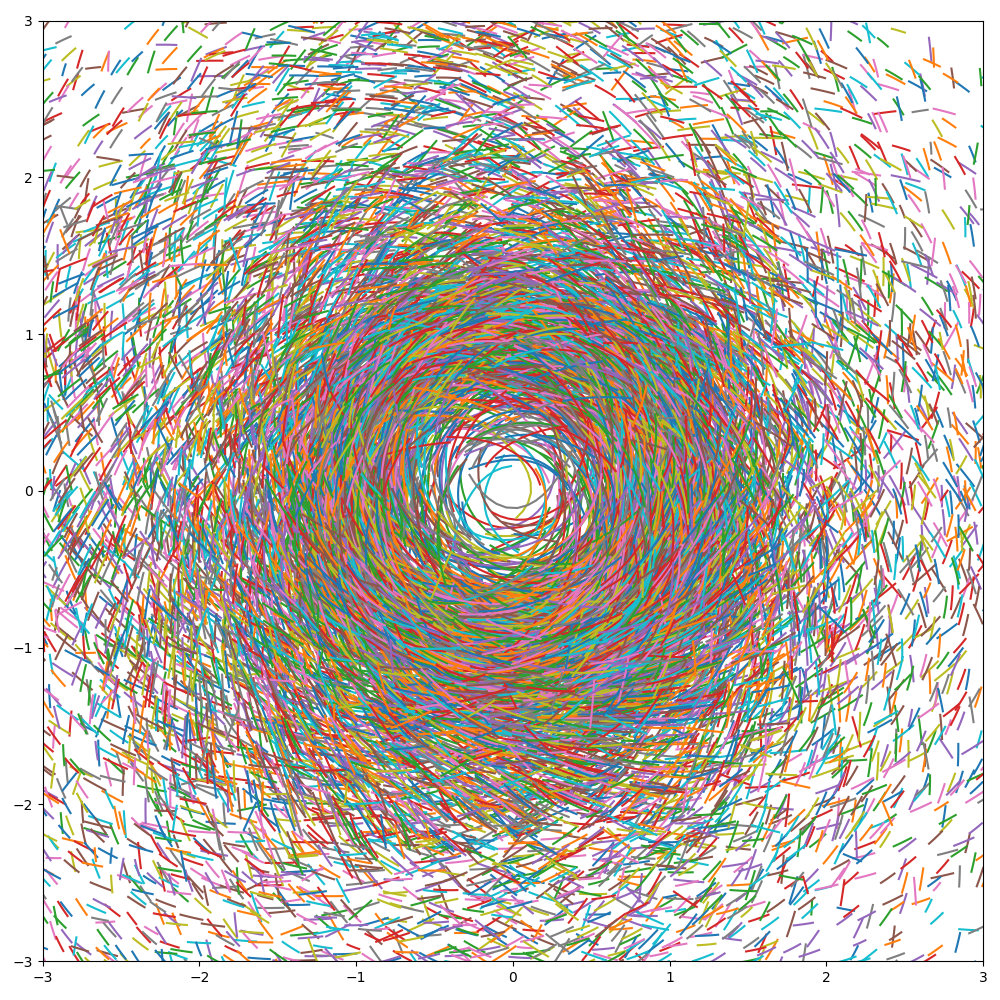

In [15]:
fig, ax = plt.subplots(figsize = (10, 10))
lines = []
for idx in range(mpc_orbits_prop_rv.shape[0]):
    lines.append(ax.plot(
        mpc_orbits_prop_rv[idx, :, 0] * (1/AU),
        mpc_orbits_prop_rv[idx, :, 1] * (1/AU),
    )[0])
ax.set_xlim(-R, R)
ax.set_ylim(-R, R)
ax.set_aspect('equal')
fig.tight_layout()

In [16]:
@widgets.interact(days = (0, 365))
def update(days = 0):
    tofs = np.arange(0, 20 * DAY, DAY, dtype = 'f8') + (DAY * days)
    mpc_orbits_prop[:, :, -1] = farnocchia_coe(
        K,
        mpc_orbits[:, None, 0],
        mpc_orbits[:, None, 1],
        mpc_orbits[:, None, 2],
        mpc_orbits[:, None, 3],
        mpc_orbits[:, None, 4],
        mpc_orbits[:, None, 5],
        tofs[None, :],
    )
    coe2rv(K, mpc_orbits_prop, mpc_orbits_prop_rv)
    for idx, line in enumerate(lines):
        line.set_data(
            mpc_orbits_prop_rv[idx, :, 0] * (1/AU),
            mpc_orbits_prop_rv[idx, :, 1] * (1/AU),
        )
    fig.canvas.draw()
    fig.canvas.flush_events()

interactive(children=(IntSlider(value=0, description='days', max=365), Output()), _dom_classes=('widget-intera…

In [17]:
def update2(days = 0):
    tofs = np.arange(0, 20 * DAY, DAY, dtype = 'f8') + (DAY * days)
    mpc_orbits_prop[:, :, -1] = farnocchia_coe(
        K,
        mpc_orbits[:, None, 0],
        mpc_orbits[:, None, 1],
        mpc_orbits[:, None, 2],
        mpc_orbits[:, None, 3],
        mpc_orbits[:, None, 4],
        mpc_orbits[:, None, 5],
        tofs[None, :],
    )
    coe2rv(K, mpc_orbits_prop, mpc_orbits_prop_rv)

"""
# cpu load generator
for idx in range(10_000):
    update2(idx)
"""

KeyboardInterrupt: 